In [1]:
# Import relevant modules and functions

# Data wrangling & visualization
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Time series modelling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
import statsmodels
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import fbprophet

# Some settings for plotting
sns.set_theme(style="whitegrid", font_scale=1.5, rc={'figure.figsize' : (15, 3)})

# Load the data

In [2]:
# Get data for Berlin-Tempelhof (ID = 002759)
id_num = '002759'
file_name = f'../data/TG_STAID{id_num}.txt'

In [3]:
# Load data into dataframe (data starts in line 15 with header)
df = pd.read_csv(file_name, header=15, parse_dates=[2])
df.head()

,STAID,SOUID,DATE,TG,Q_TG
0,2759,27488,1876-01-01,22,0
1,2759,27488,1876-01-02,25,0
2,2759,27488,1876-01-03,3,0
3,2759,27488,1876-01-04,-58,0
4,2759,27488,1876-01-05,-98,0


# Clean the data

## Check data and clean

In [4]:
# Strip and lowercase column names
df.columns = [name.strip().lower() for name in df.columns]
df.head(3)

,staid,souid,date,tg,q_tg
0,2759,27488,1876-01-01,22,0
1,2759,27488,1876-01-02,25,0
2,2759,27488,1876-01-03,3,0


In [5]:
# Define idnex
df.set_index('date', inplace=True)
df.head(3)

,staid,souid,tg,q_tg
date,,,,
1876-01-01,2759,27488,22,0
1876-01-02,2759,27488,25,0
1876-01-03,2759,27488,3,0


In [6]:
# Check type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   staid   53416 non-null  int64
 1   souid   53416 non-null  int64
 2   tg      53416 non-null  int64
 3   q_tg    53416 non-null  int64
dtypes: int64(4)
memory usage: 2.0 MB


In [7]:
# Transform temperature into degrees
df['tg'] *= 0.1

In [8]:
# Check suspicious and missing values
df.groupby('q_tg')['tg'].count()

q_tg
0    53219
1        1
9      196
Name: tg, dtype: int64

In [9]:
# Check suspicious temperature values - looks o.k.
idx = df.loc[df['q_tg']==1].index[0]
one_day = datetime.timedelta(days=1)
df.loc[idx-one_day:idx+one_day]

,staid,souid,tg,q_tg
date,,,,
1947-01-20,2759,28124,-1.3,0
1947-01-21,2759,27488,-2.7,1
1947-01-22,2759,28124,-2.8,0


In [10]:
# Check missing values - need to be handled
# 1) Start after 1945 2) Use ffill for value in 31.03.2022 (i.e. use tg of previous day)

df[df['q_tg']==9]

,staid,souid,tg,q_tg
date,,,,
1945-04-25,2759,27488,-999.9,9
1945-04-26,2759,27488,-999.9,9
1945-04-27,2759,27488,-999.9,9
1945-04-28,2759,27488,-999.9,9
1945-04-29,2759,27488,-999.9,9
...,...,...,...,...
1945-11-02,2759,27488,-999.9,9
1945-11-03,2759,27488,-999.9,9
1945-11-04,2759,27488,-999.9,9


In [11]:
# Impute or drop missing values
idx_min = df[df['q_tg']==9].index.min()
mn = df.loc[:idx_min]['tg'].mean()

def set_to_nan(x):
    if x <= -990:
        return np.nan
    else: 
        return x
    
df['tg']=df['tg'].apply(set_to_nan)
df['tg'].ffill(axis=0, inplace=True)

In [12]:
df[df['q_tg']==9].tail()

,staid,souid,tg,q_tg
date,,,,
1945-11-02,2759,27488,8.0,9
1945-11-03,2759,27488,8.0,9
1945-11-04,2759,27488,8.0,9
1945-11-05,2759,27488,8.0,9
2022-03-31,2759,11448,5.3,9


## Create functions for cleaning

In [13]:
def clean_df(df):
    """
    Cleans the dataframe extracted with read_txt and returns pivoted table with temperatures
    """
    df.columns = [name.strip().lower() for name in df.columns]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    df['tg'] = df['tg'].apply(set_to_nan)
    df['tg'].ffill(axis=0, inplace=True)
    df['tg'] = df['tg'].apply(lambda x: int(x) * 0.1)
    #df = df.pivot(columns='staid', values='tg')   
    return df[['tg']]

In [14]:
clean_df(pd.read_csv(file_name, header=15, parse_dates=[2])).head(3)

,tg
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3


## Visualize the data

In [15]:
df.reset_index(inplace=True)
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df.set_index('date', inplace=True)
#df.drop('index', axis=1, inplace=True)
df.head(3)

,staid,souid,tg,q_tg,year,month
date,,,,,,
1876-01-01,2759,27488,2.2,0,1876,1
1876-01-02,2759,27488,2.5,0,1876,1
1876-01-03,2759,27488,0.3,0,1876,1


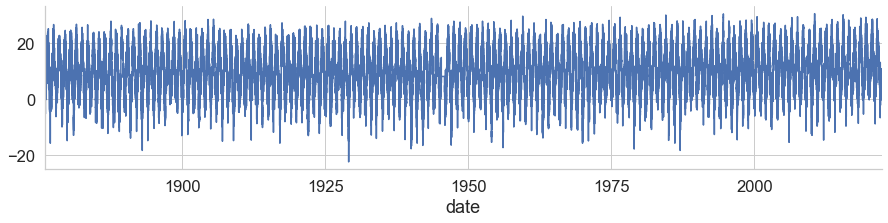

In [16]:
# All data 
df['tg'].plot()
sns.despine()

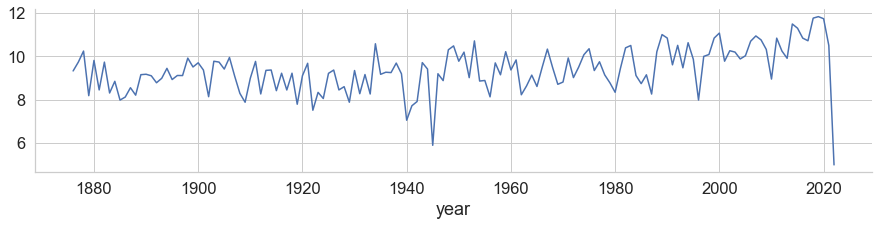

In [17]:
# Grouped by years taking the mean
df.groupby(['year'])['tg'].mean().plot()
sns.despine()

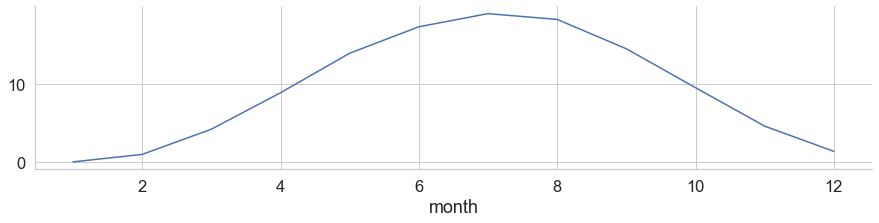

In [18]:
# Grouped by months taking the mean 
df.groupby('month')['tg'].mean().plot()
sns.despine()

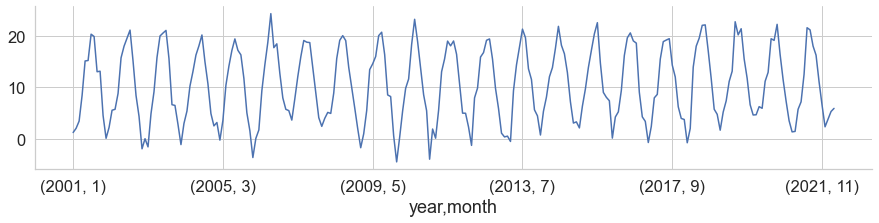

In [19]:
# Grouped by years and months taking the mean (since 2000)
df[df['year'] > 2000].groupby(['year', 'month'])['tg'].mean().plot()
sns.despine()

# Add timestep and seasonal dummies

In [20]:
def add_timestep(df):   
    df = df.reset_index().reset_index().set_index('date')
    df.rename(columns={'index':'timestep'}, inplace=True)
    return df

In [21]:
df = add_timestep(df)
df.head(3)

,timestep,staid,souid,tg,q_tg,year,month
date,,,,,,,
1876-01-01,0,2759,27488,2.2,0,1876,1
1876-01-02,1,2759,27488,2.5,0,1876,1
1876-01-03,2,2759,27488,0.3,0,1876,1


In [22]:
def add_sea_dummies(df):
    seasonal_dummies = pd.get_dummies(df.index.month, prefix='month',
                                  drop_first=True).set_index(df.index)
    df = df.join(seasonal_dummies)
    return df

In [23]:
df = add_sea_dummies(df)
df.head(3)

,timestep,staid,souid,tg,q_tg,year,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,
1876-01-01,0,2759,27488,2.2,0,1876,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,2759,27488,2.5,0,1876,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,2759,27488,0.3,0,1876,1,0,0,0,0,0,0,0,0,0,0,0


# Train-test-split the data

In [24]:
# Select data for model -> We will use only data after 1950
df_train = df[df.index.year >= 1950].copy()[:-365]
df_test = df[df.index.year >= 1950].copy()[-365:]
df_train.shape, df_test.shape

((26023, 18), (365, 18))

# Model trend and seasonal effects 

## Model trend

In [25]:
X_train = df_train[['timestep']]
y_train = df_train['tg']

In [26]:
X_train.shape, y_train.shape

((26023, 1), (26023,))

In [27]:
m_t = LinearRegression()
m_t.fit(X_train, y_train)
df_train['trend'] = m_t.predict(X_train)

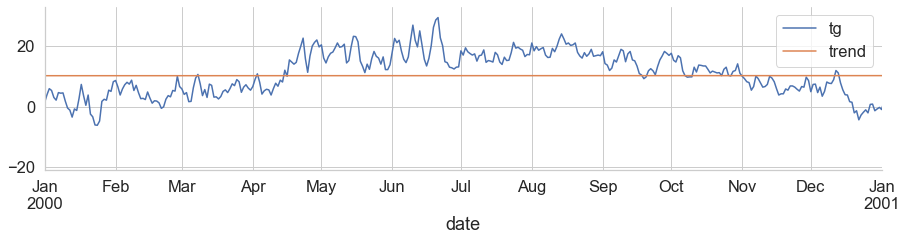

In [28]:
ax = df_train[['tg', 'trend']].plot()
ax.set_xlim(['2000','2001'])
sns.despine()

## Model trend and seasonal impact

In [29]:
# Define relevant columns (=feature_columns)
list_months = [f'month_{i+2}' for i in range(11)]
feature_columns = ['timestep'] + list_months 
feature_columns

['timestep',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [30]:
X_train = df_train[feature_columns]
y_train = df_train['tg'] 

In [31]:
m_ts = LinearRegression()
m_ts.fit(X_train, y_train)
df_train['trend_and_seasonal'] = m_ts.predict(X_train)

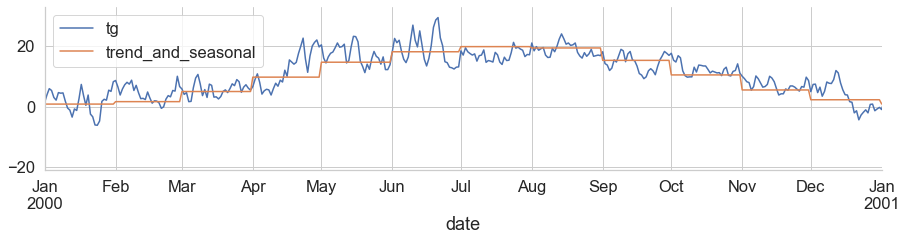

In [32]:
ax = df_train[['tg', 'trend_and_seasonal']].plot()
ax.set_xlim(['2000','2001'])
sns.despine()

# Extract the remainder

In [33]:
df_train['remainder'] = df_train['tg'] - df_train['trend_and_seasonal']

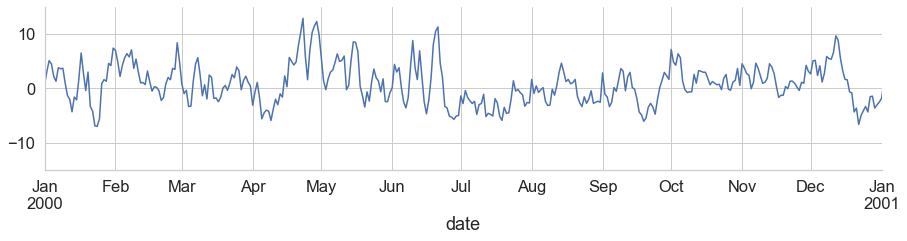

In [34]:
df_train['remainder'].plot(xlim=['2000','2001'], ylim=[-15,15])
sns.despine();

In [35]:
# Analyzing the remainder via Augmented Dickey-Fuller Test -> Looks very stationary
statsmodels.tsa.stattools.adfuller(df_train['remainder'])

(-23.08679025190848,
 0.0,
 31,
 25991,
 {'1%': -3.43060162348338,
  '5%': -2.861651210148198,
  '10%': -2.566829193877722},
 117067.21612687121)

# Determine how many lags to use

(-0.2, 1.0)

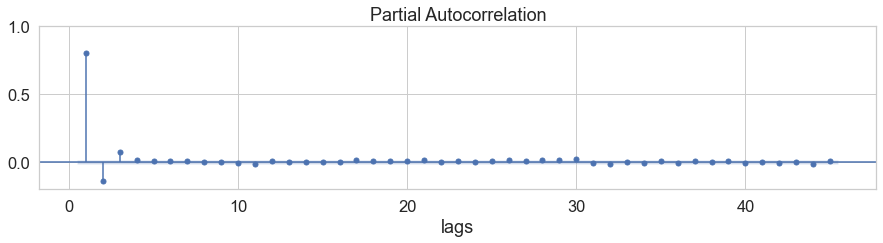

In [36]:
# Correlation vs. remainder without indirect effects - statsmodels provides a function called 
# plot_pacf to plot partial autocorrelation function
# --> 1-3 lages could be helpful, too be as simple as possible, 1 lag will be taken
plot_pacf(df_train['remainder'], method="ywm", zero=False)
plt.xlabel('lags');
plt.ylim(-0.2, 1)

# Add lags to data 

_Not required, implicitely done in modelling process_

# Run the full modell

In [37]:
# Get the data
df = pd.read_csv(file_name, header=15, parse_dates=[2])
# clean data
df = clean_df(df)
# Add features
df = add_timestep(df)
df = add_sea_dummies(df)

In [38]:
# Split into test and train
df_train = df[df.index.year >= 1950].copy()[:-365]
df_test = df[df.index.year >= 1950].copy()[-365:] 

In [39]:
# Define starting X_train, y_train
X_train = df_train.drop('tg', axis = 1)
y_train = df_train['tg'] 

In [40]:
X_train.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [41]:
# Define function for modelling

def do_iterative_modelling(df, X, y, method, models=None, lags=1):
    """
    Performs iterative modelling with customized lags, returns dataframe, X and y as well as 
    model; use_tg turns on usage of tg as lag variable
    """
    # Get (copys to avoid warnings)
    X = X.copy()
    if not method == 'predict':
        y = y.copy()
    df = df.copy()
        
    # Define initial predictions
    predictions = y_train.copy() * 0

    # Start iterative modelling process
    for i in range(1 + int(lags>0)): 
        
        # Add lag variables from predictions and target
        if i > 0:
            for l in range(1, 1+lags):
                # Define X for modelling and save results in df
                X[f'lag_{l}'] = (y - predictions).shift(l)
                df[f'lag_{l}'] = (y - predictions).shift(l)

            # Eliminate first rows with NaNs
            X = X[lags:]
            y = y[lags:]
        
        # Create modell
        m = LinearRegression()
        # Create list to store models if None
        if models == None:
            models = []
        
        # Train model if needed, otherwise get trained model
        if method == 'train':
            # Fit model
            m.fit(X, y)
            # Save model
            models.append(m)
        else:
            m = models[i]
        
        # Get predictions
        predictions = m.predict(X)

        # Save predictions in df (use X as vehicle to get the index)
        name = 'trend_and_seasonal'
        if i == 1:
            name = 'full_model'
        
        X[name] = predictions
        df = df.join(X[name], how='left')
        X = X.drop(name, axis = 1)
       
        # Print out score for the models
        if not method == 'predict':
            # Determine score for model
            m_score = m.score(X, y)
            # Print results 
            if i==0:
                print(f'Evaluation of model without lags -> Score = {m_score}')
            if i==1:
                if lags == 1:
                    print(f'Evaluation of model with {lags} lag -> Score = {m_score}')
                else:
                    print(f'Evaluation of model with {lags} lags -> Score = {m_score}')
            
    return df, X, y, models

In [42]:
# Perform modelling
df_train, X_train, y_train, models = do_iterative_modelling(
    df_train, X_train, y_train, 
    method='train', lags=1)

m_full = models[-1]

Evaluation of model without lags -> Score = 0.7524175660467751
Evaluation of model with 1 lag -> Score = 0.912523195455811


In [43]:
df_train.head()

,timestep,tg,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_and_seasonal,lag_1,full_model
date,,,,,,,,,,,,,,,,
1950-01-01,27028,-3.5,0,0,0,0,0,0,0,0,0,0,0,-0.506880,NaN,NaN
1950-01-02,27029,1.0,0,0,0,0,0,0,0,0,0,0,0,-0.506808,-2.993120,-2.884187
1950-01-03,27030,2.9,0,0,0,0,0,0,0,0,0,0,0,-0.506737,1.506808,0.735225
1950-01-04,27031,-0.1,0,0,0,0,0,0,0,0,0,0,0,-0.506665,3.406737,2.263430
1950-01-05,27032,-3.0,0,0,0,0,0,0,0,0,0,0,0,-0.506594,0.406665,-0.149488


# Plot the model results

In [44]:
# Calculate predictions for different models via coefficients of trained modell
def add_decomposed_results(df):
    """
    Get results for trend, trend_and_seasonality and full_modell (=result highest prediction);
    returns dataframe
    """
    df = df.copy()

    df['trend'] = m_full.intercept_
    for coef, feature in zip(m_full.coef_[0:1], m_full.feature_names_in_[0:1]):
        df['trend'] += coef * df[feature]

    df['trend_and_seasonal'] = m_full.intercept_
    for coef, feature in zip(m_full.coef_[:-1], m_full.feature_names_in_[:-1]):
        df['trend_and_seasonal'] += coef * df[feature] 
        
    df['full_modell'] = m_full.intercept_
    for coef, feature in zip(m_full.coef_[:], m_full.feature_names_in_[:]):
        df['full_modell'] += coef * df[feature] 

    return df

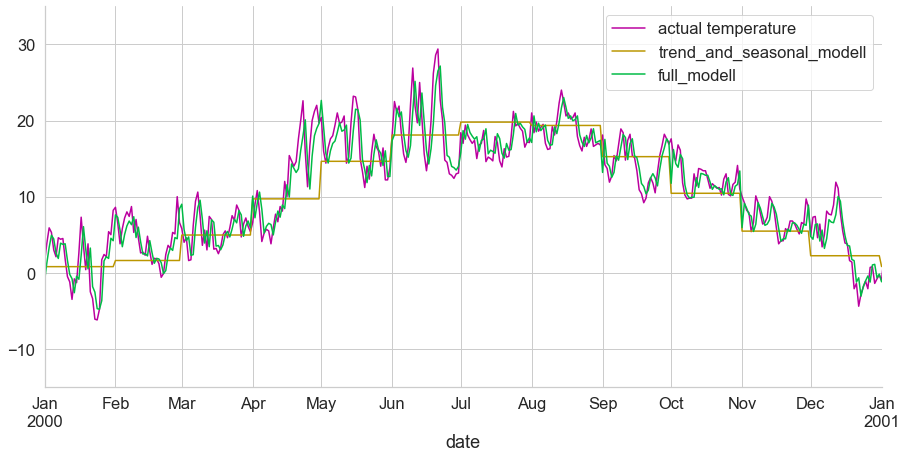

In [45]:
# Add decomposed results
#df_train = add_decomposed_results(df_train) # not required anymore

labels = ['actual temperature', 'trend_and_seasonal_modell', 'full_modell']
colors = ['#bb009f', '#bb9600', '#00bb45']

df_train[['tg', 'trend_and_seasonal', 'full_model']].plot(color=colors, figsize=(15,7))

plt.xlim('2000','2001')
plt.ylim(-15,35)
plt.legend(labels)
sns.despine()

f_name = 'prediction_2019.png'
plt.savefig(f'{f_name}', dpi = 250, transparent=True) 

# Evaluate the full model

## Model results

In [46]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [47]:
# Create the time series split
time_series_split = ts_split.split(X_train, y_train) 

In [48]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_train, y=y_train,
                         cv=time_series_split)
result

array([0.91302383, 0.91012021, 0.90222975, 0.91545962, 0.91712432])

In [49]:
result.mean()

0.911591544890945

## Residual analysis

In [50]:
df_train['residual'] = df_train['tg'] - df_train['full_model']
df_train.head(3)

,timestep,tg,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_and_seasonal,lag_1,full_model,residual
date,,,,,,,,,,,,,,,,,
1950-01-01,27028,-3.5,0,0,0,0,0,0,0,0,0,0,0,-0.506880,NaN,NaN,NaN
1950-01-02,27029,1.0,0,0,0,0,0,0,0,0,0,0,0,-0.506808,-2.993120,-2.884187,3.884187
1950-01-03,27030,2.9,0,0,0,0,0,0,0,0,0,0,0,-0.506737,1.506808,0.735225,2.164775


In [51]:
# Dickey - Fuller Test to check residual - looks even more "white noiseishis"
statsmodels.tsa.stattools.adfuller(df_train['residual'][1:])

(-25.58918892208018,
 0.0,
 32,
 25989,
 {'1%': -3.4306016428491377,
  '5%': -2.8616512187069287,
  '10%': -2.5668291984333447},
 117060.89141019945)

# Test the model

In [52]:
# Redefine df_test
# - Missing value for 31.3.2022 (=last day) - potentially to be replaced by tg of previous day?
# - Add last row from df_train since we are using one lag
df_test = df[df.index.year >= 1950].copy()[-366:] 

In [53]:
df_train.head(3)

,timestep,tg,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_and_seasonal,lag_1,full_model,residual
date,,,,,,,,,,,,,,,,,
1950-01-01,27028,-3.5,0,0,0,0,0,0,0,0,0,0,0,-0.506880,NaN,NaN,NaN
1950-01-02,27029,1.0,0,0,0,0,0,0,0,0,0,0,0,-0.506808,-2.993120,-2.884187,3.884187
1950-01-03,27030,2.9,0,0,0,0,0,0,0,0,0,0,0,-0.506737,1.506808,0.735225,2.164775


In [54]:
# Define X_test and y_test
X_test = df_test.drop('tg', axis = 1)
y_test = df_test['tg'] 

In [55]:
# Perform modelling
df_test, X_test, y_test, modells = do_iterative_modelling(
    df_test, X_test, y_test, 
    method='test', models = models, lags=1)

Evaluation of model without lags -> Score = 0.7579962607597125
Evaluation of model with 1 lag -> Score = 0.9128776511550115


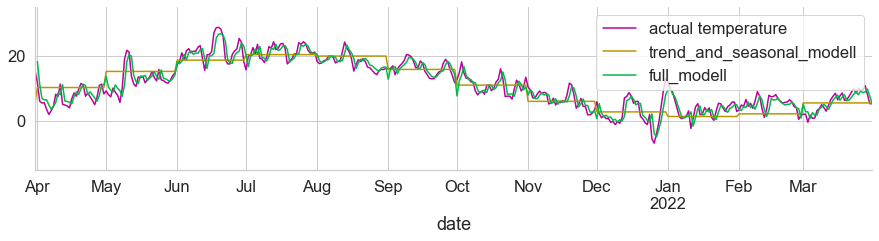

In [56]:
# Add decomposed results
#df_test = add_decomposed_results(df_test)

labels = ['actual temperature', 'trend_and_seasonal_modell', 'full_modell']
colors = ['#bb009f', '#bb9600', '#00bb45']

df_test[['tg', 'trend_and_seasonal', 'full_model']].plot(color=colors)

#plt.xlim('2000','2001')
plt.ylim(-15,35)
plt.legend(labels)
sns.despine()

# Predict the future

## Build a combined model

In [57]:
# - Missing value for 31.3.2022 (=last day) - potentially to be replaced by tg of previous day?
df_com = df[df.index.year >= 1950].copy()[:-1] 

In [58]:
# Define X and y
X_com = df_com.drop('tg', axis = 1)
y_com = df_com['tg'] 

In [59]:
# Perform modelling
df_com, X_com, y_com, models = do_iterative_modelling(
    df_com, X_com, y_com, 
    method='train', lags=1)

m_full = models[-1]

Evaluation of model without lags -> Score = 0.7526246723250065
Evaluation of model with 1 lag -> Score = 0.9125666145359741


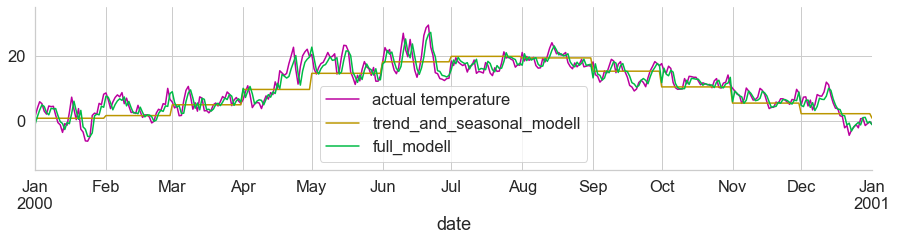

In [60]:
# Add decomposed results
#df_com = add_decomposed_results(df_com)

legend = ['actual temperature', 'trend_and_seasonal_modell', 'full_modell']
colors = ['#bb009f', '#bb9600', '#00bb45']

df_com[['tg', 'trend_and_seasonal', 'full_model']].plot(color=colors)

plt.xlim('2000','2001')
plt.ylim(-15,35)
plt.legend(labels)
sns.despine()

## Predict next timestep

In [61]:
# Build future dataframe based on extracted last row
def get_future_df(df_last):
    df_future = pd.DataFrame(df_last.iloc[-1,:]).transpose()
    idx_old = df_future.index[0]
    idx_new = idx_old + one_day

    df_future.loc[idx_new] = 0
    df_future.loc[idx_new, 'timestep'] = df_future.loc[idx_old, 'timestep'] + 1
    if df_future.index.month[1] > 1:
        df_future.loc[idx_new, f'month_{df_future.index.month[1]}'] = 1.0

    return df_future

In [62]:
# Get future dataframe
df_future = get_future_df(df)
df_future.loc['2022, 3, 31', 'tg'] = df.loc['2022, 3, 30', 'tg'] # Needs to be handled in data cleaning!
df_future

,timestep,tg,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2022-03-31,53415.0,5.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01,53416.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Define future X and y
X_future = df_future.drop('tg', axis=1)
y_future = df_future['tg']

In [64]:
# Perform prediction
df_future, X_future, y_future, modells = do_iterative_modelling(
    df_future, X_future, y_future, 
    method='predict', models=models, lags=1)

In [65]:
# Add decomposed results
print(f"Trend and seasonal model predicts {round(df_future['trend_and_seasonal'][-1], 1)}°C")
print(f"Full modell predicts {round(df_future['full_model'][-1], 1)}°C")
# is equal to -> m_full.predict(X_future)

Trend and seasonal model predicts 10.2°C
Full modell predicts 10.1°C


# Other modelling options

## AutoReg model (Statmodels)

In [66]:
# Get the data
df = pd.read_csv(file_name, header=15, parse_dates=[2])
# clean data
df = clean_df(df)
# Add features
df = add_timestep(df)
df = add_sea_dummies(df)

In [67]:
# Split into test and train
df_train = df[df.index.year >= 1950].copy()[:-365]
df_test = df[df.index.year >= 1950].copy()[-365:] 

In [68]:
# Define starting X_train, y_train
X_train = df_train.drop('tg', axis = 1)
y_train = df_train['tg'] 

In [69]:
# Perform modelling, but with lags=1. However, only trend_and_seasonal will be used!!!
df_train, X_train, y_train, models = do_iterative_modelling(
    df_train, X_train, y_train, 
    method='train', lags=1)

m_ts = models[0]

Evaluation of model without lags -> Score = 0.7524175660467751
Evaluation of model with 1 lag -> Score = 0.912523195455811


In [70]:
# Determine remainder to be modelled with AR model
df_train['remainder'] = df_train['tg'] - df_train['trend_and_seasonal']
df_train.head(3)

,timestep,tg,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_and_seasonal,lag_1,full_model,remainder
date,,,,,,,,,,,,,,,,,
1950-01-01,27028,-3.5,0,0,0,0,0,0,0,0,0,0,0,-0.506880,NaN,NaN,-2.993120
1950-01-02,27029,1.0,0,0,0,0,0,0,0,0,0,0,0,-0.506808,-2.993120,-2.884187,1.506808
1950-01-03,27030,2.9,0,0,0,0,0,0,0,0,0,0,0,-0.506737,1.506808,0.735225,3.406737


In [71]:
# Create an AR model - as before we use 1 lag 
ar_model = AutoReg(endog=df_train['remainder'], lags=1, trend='n').fit()

/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [72]:
# Summary shows lag1 is significant, however, constant term could even be dropped
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                26023
Model:                     AutoReg(1)   Log Likelihood              -58991.708
Method:               Conditional MLE   S.D. of innovations              2.335
Date:                Mon, 02 May 2022   AIC                         117987.416
Time:                        21:55:09   BIC                         118003.749
Sample:                    01-02-1950   HQIC                        117992.692
                         - 03-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
remainder.L1     0.8042      0.004    218.220      0.000       0.797       0.811
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2434           +0.0000j            1.2434            0.0000
-----------------------------------------------------------------------------
"""

In [73]:
# Save predictions of AR model in Dataframe
df_train['ar_prediction'] = ar_model.predict()

(-15.0, 15.0)

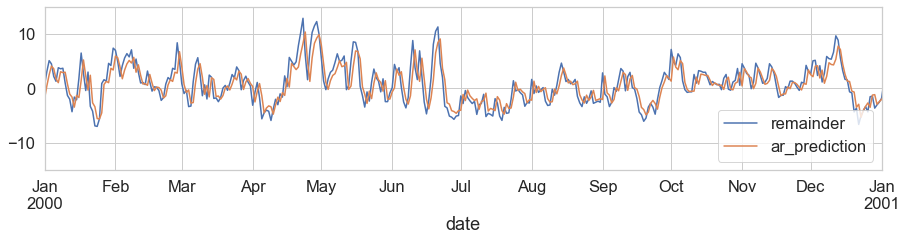

In [74]:
# Plot predictions of the remainder vs. prediction of AR model
df_train[['remainder', 'ar_prediction']].plot()
plt.xlim('2000', '2001')
plt.ylim(-15, 15)

In [75]:
# Calculate overall prediction (i.e. incl. trend and seasonality)
df_train['full_model_ar'] = df_train['trend_and_seasonal'] + df_train['ar_prediction']

(-20.95, 32.95)

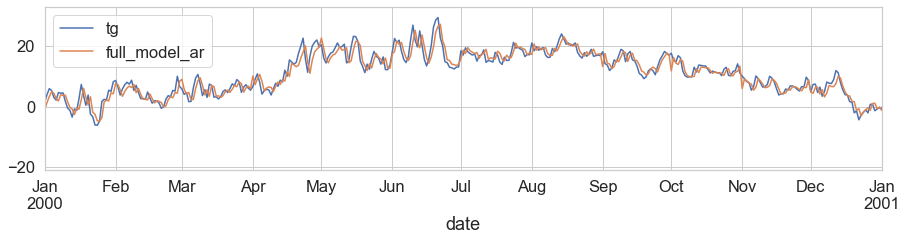

In [76]:
# Plot predictions of the remainder vs. prediction of AR model
df_train[['tg', 'full_model_ar']].plot()
plt.xlim('2000', '2001')
plt.ylim()

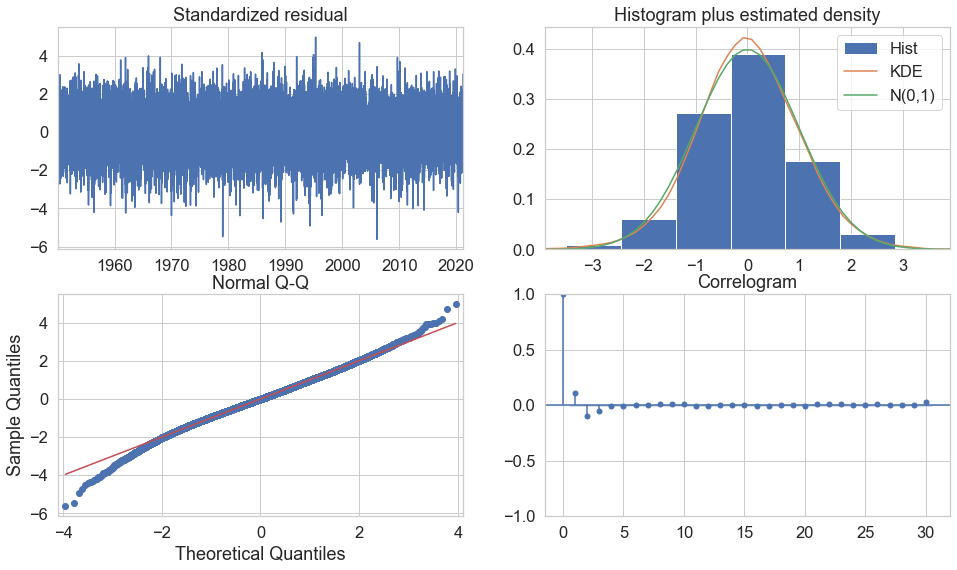

In [77]:
# Validate the model -> Look at the residual, looks good 
fig = plt.figure(figsize=(16, 9))
fig = ar_model.plot_diagnostics(fig=fig, lags=30)

/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


(-15.0, 15.0)

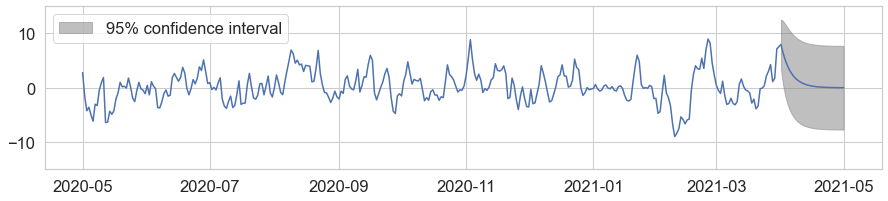

In [78]:
# Forecast the remainder with AR model
fig = ar_model.plot_predict('2020, 5, 1', '2021, 5, 1')
plt.ylim(-15,15)

## Arima (Statmodels)

__Workflow__ is well described [here](https://towardsdatascience.com/hands-on-time-series-forecasting-with-python-d4cdcabf8aac?gi=de5b42d19198) and comprises the follwoing steps:
- __Iterative process__ of:
    - Identification
    - Estimation
    - Validation
- Forcasting

Text(0.5, 0, '# of lags')

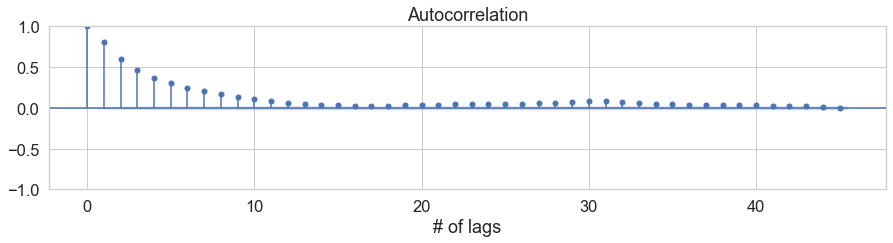

In [79]:
# p (number of lags) = 1 already determined
# q (number of lags for moving averages of errors) can be determined via autocorrelation chart
# 1-5 could be valid, will find out via auto_arima
plot = plot_acf(df_train['remainder'])
plt.xlabel('# of lags')

In [80]:
# Optimal factors can also be identified with auto_arima from pmdarima library
# Warning: Wanting to find optimal parameters for seasonal data takes very long,
# i.e. seasonality has to be eliminated apriori
arima_opt = pm.auto_arima(df_train['remainder'],
                      start_p=0, max_p=5,
                      max_d=1,
                      start_q=0, max_q=5,
                      test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=145062.472, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=117994.571, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=127206.731, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=145060.472, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=117488.717, Time=0.67 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=117346.502, Time=0.85 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=117341.027, Time=1.03 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=117341.894, Time=1.51 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=117339.709, Time=12.88 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=117339.362, Time=5.92 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=117385.852, Time=2.65 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=117340.262, Time=1.63 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=117342.117, Time=4.35 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=117343.348, Time=7.01 sec
 ARI

In [81]:
# Check model statistics, all identified factors highly likely != 0 
arima_opt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                26023
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -58663.681
Date:                Mon, 02 May 2022   AIC                         117337.362
Time:                        21:56:09   BIC                         117378.196
Sample:                             0   HQIC                        117350.553
                              - 26023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1946      0.073     16.367      0.000       1.052       1.338
ar.L2         -0.4524      0.066     -6.855      0.000      -0.582      -0.323
ar.L3          0.1111      0.010     10.651      0.000       0.091       0.132
ma.L1         -0.2699      0.073     -3.678      0.000      -0.414      -0.126
sigma2         5.3157      0.041    129.760      0.000       5.235       5.396
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               558.18
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
df_train['arima_prediction'] = arima_opt.predict_in_sample()

In [83]:
# Alternative with classic arima definition -> predict comprises in-sample prediction
# arima = ARIMA(endog=df_train['remainder'], order=(3,0,1)).fit()
# df_train['arima_prediction'] = arima.predict()

(-15.0, 15.0)

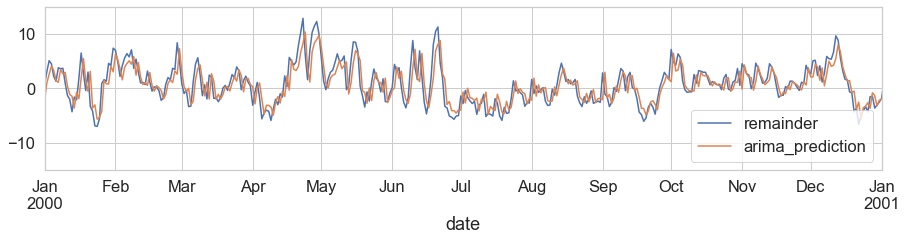

In [84]:
df_train[['remainder', 'arima_prediction']].plot()
plt.xlim('2000', '2001')
plt.ylim(-15, 15)

In [85]:
# Calculate overall prediction (i.e. incl. trend and seasonality)
df_train['full_model_arima'] = df_train['trend_and_seasonal'] + df_train['arima_prediction']

(-20.95, 32.95)

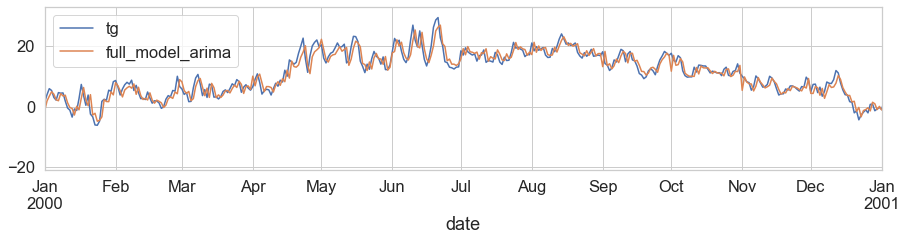

In [86]:
# Plot predictions of the remainder vs. prediction of AR model
df_train[['tg', 'full_model_arima']].plot()
plt.xlim('2000', '2001')
plt.ylim()

## Comparison between AR and ARIMA 

(-15.0, 15.0)

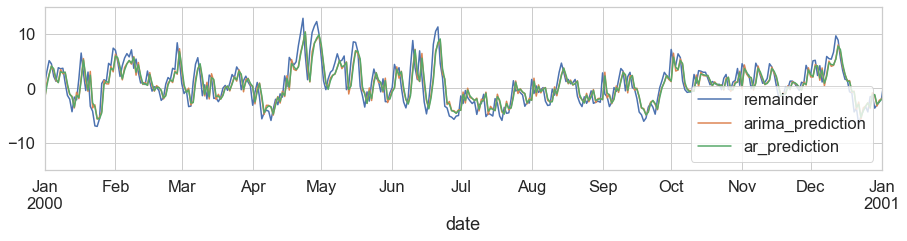

In [87]:
df_train[['remainder', 'arima_prediction', 'ar_prediction']].plot()
plt.xlim('2000', '2001')
plt.ylim(-15, 15)

In [88]:
# Check whether self-made AR function works
ar_error = round(mean_absolute_error(df_train['tg'][1:], df_train['full_model_ar'][1:]),3)
arima_error = round(mean_absolute_error(df_train['tg'][1:], df_train['full_model_arima'][1:]),3)
lin_error = round(mean_absolute_error(df_train['tg'][1:], df_train['full_model'][1:]),3)

In [89]:
print(f'Mean absolute error for self-made lin auto-regression: {lin_error}')
print(f'This should be equal to the mean absolute error for Auto Regression: {ar_error}')
print(f'Hopefull the mean absolute error for ARIMA is higher: {ar_error}')

Mean absolute error for self-made lin auto-regression: 1.823
This should be equal to the mean absolute error for Auto Regression: 1.823
Hopefull the mean absolute error for ARIMA is higher: 1.823


In [90]:
# Compare seasonal_and_trend vs. auto-regression vs. ARIMA
base_model_error = round(mean_absolute_error(df_train['tg'][1:], df_train['trend_and_seasonal'][1:]), 1)
ar_error = round(mean_absolute_error(df_train['tg'][1:], df_train['full_model_ar'][1:]), 1)
arima_error = round(mean_absolute_error(df_train['tg'][1:], df_train['full_model_arima'][1:]), 1)

In [91]:
f'Mean absolute error for the base model {base_model_error}, the  Auto Regression: {ar_error} and  ARIMA {arima_error}'

'Mean absolute error for the base model 3.1, the  Auto Regression: 1.8 and  ARIMA 1.8'

## Facebook prophet

In [92]:
# Copy dataframe for manipulation
df_p = df_train[['tg']].reset_index()
df_p.head(3)

,date,tg
0,1950-01-01,-3.5
1,1950-01-02,1.0
2,1950-01-03,2.9


In [93]:
#df_p.iloc[-1,1] = df_p.iloc[-2,1] 
#df_p.tail(3)

In [94]:
# Prophet requires columns ds (Date) and y (value)
gm = df_p.rename(columns={'date': 'ds', 'remainder': 'y', 'tg': 'y'})
gm.head(3)

,ds,y
0,1950-01-01,-3.5
1,1950-01-02,1.0
2,1950-01-03,2.9


In [95]:
# Create the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(interval_width=0.95)

gm_prophet.fit(gm);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1421.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       41305.1    0.00187015        258.86           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       41306.9   0.000189011       443.164   4.391e-07       0.001      178  LS failed, Hessian reset 
     152       41311.5   0.000228832       251.817   1.366e-06       0.001      275  LS failed, Hessian reset 
     199       41313.4   0.000355434       263.183      0.6086      0.6086      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       41318.1    0.00267302       335.264      0.4967           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       41318.9    4.0506e-05       93.2129    2.18e-07       0.001      554  LS failed, Hessian rese

## In-sample prediction

In [96]:
forecast_is = gm_prophet.predict(gm)

/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [97]:
df_train['full_model_prophet'] = forecast_is.set_index('ds')['yhat']

In [98]:
prophet_error = round(mean_absolute_error(df_train['remainder'][1:], df_train['full_model_prophet'][1:]),3)
prophet_error

10.517

(-10.0, 30.0)

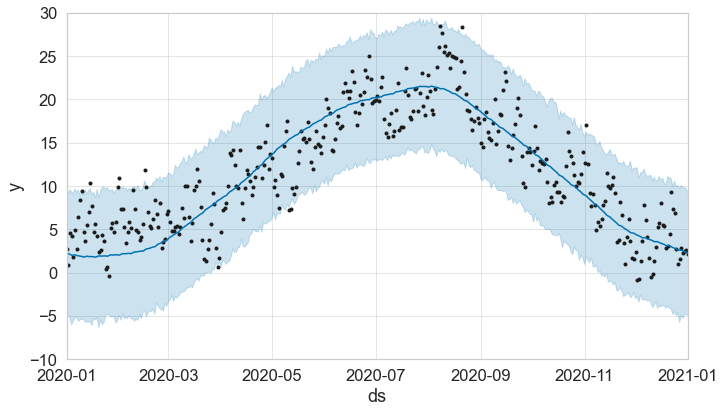

In [99]:
fig = gm_prophet.plot(forecast_is)
plt.xlim([datetime.datetime(2020, 1, 1), datetime.datetime(2021, 1, 1)])
plt.ylim(-10,30)

## Forecast

In [100]:
future = gm_prophet.make_future_dataframe(periods=365)

In [101]:
forecast = gm_prophet.predict(future)

/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/philipwitte/.conda/envs/prophet/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


(-10.0, 30.0)

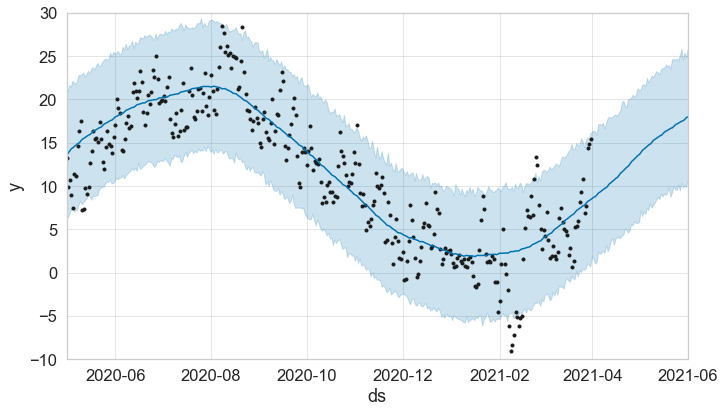

In [102]:
fig = gm_prophet.plot(forecast)
plt.xlim([datetime.datetime(2020, 5, 1), datetime.datetime(2021, 6, 1)])
plt.ylim(-10,30)